# **🏠 Data EDA**
> 생성한 데이터를 활용하여 여러 방면에서 생각해본 데이터 EDA

## Contents
- Library Import
- Data Load
- Data EDA

## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [245]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import geopy

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

In [166]:
# 데이터 불러오기
tmp = pd.read_csv('../data/train.csv')
train = pd.read_csv('../data/KOREAN_train4.csv')
test = pd.read_csv('../data/KOREAN_test4.csv')
brand = pd.read_csv('../data/아파트브랜드top24.csv', encoding='utf-8')
goldwe = pd.read_excel('../data/한국은행_금리.xlsx')

In [167]:
# 정규표현식 패턴 생성
pattern = '|'.join(brand['브랜드명'])

# '열이름' 열에서 패턴이 있는지 확인하여 새로운 열 추가
train['아파트브랜드'] = train['아파트명'].str.contains(pattern)

In [168]:
# 아파트브랜드면 1 아니면 0
train['아파트브랜드'].value_counts()

False    933959
True     182737
Name: 아파트브랜드, dtype: int64

In [169]:
train.columns

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       '해제사유발생일', '거래유형', '중개사소재지', 'k-단지분류', 'k-세대타입(분양형태)', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-시행사', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황60이하', 'k-전용면적별세대현황6085이하', 'k-85135이하', 'k-135초과',
       '세대전기계약방법', '건축면적', '주차대수', '기타의무임대1234', '단지신청일', 'target', '구', '동',
       '전체주소명', '동아파트명', '유동인구', '아파트 지하철역 거리', '1차역세권', '2차역세권',
       '아파트 버스정류장 거리', '좌표X', '좌표Y', '아파트 한강대교 거리', '전세가율', '전체계약일자', '금리',
       '실질gdp', '명목gdp', '학군', '재개발개수', '학급수', '여당득표율', '아파트브랜드'],
      dtype='object')

In [170]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 54 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   시군구                1118822 non-null  object 
 1   번지                 1118822 non-null  object 
 2   아파트명               1116696 non-null  object 
 3   전용면적               1118822 non-null  float64
 4   계약년월               1118822 non-null  int64  
 5   계약일                1118822 non-null  int64  
 6   층                  1118822 non-null  int64  
 7   건축년도               1118822 non-null  int64  
 8   도로명                1118822 non-null  object 
 9   해제사유발생일            5983 non-null     float64
 10  거래유형               32371 non-null    object 
 11  중개사소재지             29241 non-null    object 
 12  k-단지분류             248131 non-null   object 
 13  k-세대타입(분양형태)       249259 non-null   object 
 14  k-복도유형             248932 non-null   object 
 15  k-난방방식             249259 non-nu

In [171]:
train.isna().sum()

시군구                        0
번지                         0
아파트명                    2126
전용면적                       0
계약년월                       0
계약일                        0
층                          0
건축년도                       0
도로명                        0
해제사유발생일              1112839
거래유형                 1086451
중개사소재지               1089581
k-단지분류                870691
k-세대타입(분양형태)          869563
k-복도유형                869890
k-난방방식                869563
k-전체동수                870630
k-전체세대수               869563
k-건설사                 871058
k-시행사                 871254
k-연면적                 869563
k-주거전용면적              869608
k-전용면적별세대현황60이하       869608
k-전용면적별세대현황6085이하     869608
k-85135이하             869608
k-135초과              1118495
세대전기계약방법              878747
건축면적                  869714
주차대수                  869714
기타의무임대1234            869563
단지신청일                 869625
target                     0
구                          0
동                          0
전체주소명         

In [172]:
# 연식년도 생성
train['연식'] = train['계약년월'] // 100 - train['건축년도']
test['연식'] = test['계약년월'] // 100 - test['건축년도']

In [173]:
train = train[train['계약년월'] >= 201701]
train = train[train['target'] > 6111.11]
train[['연', '월']] = train['계약년월'].apply(lambda x: list(divmod(x, 100))).tolist()

# 정규표현식 패턴 생성
excluded_apts = ['AirPalace', 'SRvill', '경동팰리스힐', '대길B', '썬앤빌', '재선주택', '코원']

# go
pattern = '|'.join(excluded_apts)

# '열이름' 열에서 패턴이 있는지 확인하여 새로운 열 추가
train['is_아파트'] = np.where(train['아파트명'].str.contains(pattern), 1, 0)

train = train[train['is_아파트'] == 0]

train = train.drop(columns='is_아파트')

In [174]:
train2 = train[train['계약년월'] >= 201701]

## 3. Data EDA

- 건축 연식에 대해 영향을 받을 것이라는 생각에 계약날짜 기준별 연식을 생성
- 계약년도가 더 느린 아파트에 대해 확인해보니 최대 1년 2개월정도
- 실제로 계약이 먼저되는 경우도 있다함

In [175]:
# 계약년도가 더 빠른 아파트에 대해 연식을 0으로 부여
train2['연식'][train2['연식'] < 0] = 0
train2['log_target'] = np.log1p(train2['target'])

<Axes: xlabel='연식', ylabel='target'>

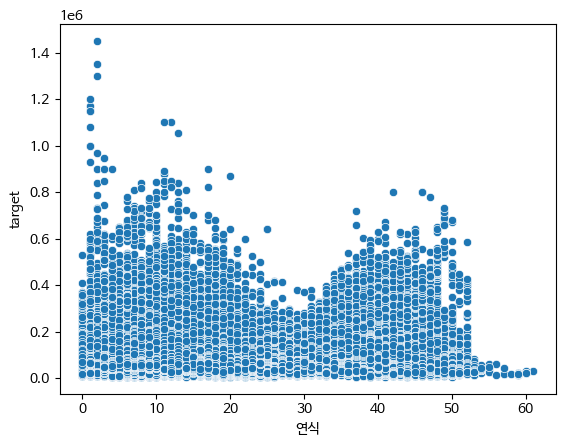

In [176]:
# 연식 별 아파트값 비교
sns.scatterplot(data = train2, x = '연식', y = 'target')

- 실제로 연식이 오래되면 아파트 값의 분포가 더 낮아지는 것을 확인할 수 있음
- 30년 이상된 아파트로부터 재건축 된 아파트는 값이 높아져서 두번째 봉우리가 생성되었을 가능성이 있음
- 그러나 재건축 여부를 데이터에서 알기 어렵기 때문에 실제로 반영이 힘듬

In [2]:
# 범주 형태로 확인
cri = [
    train2['연식'] > 10,
    (train2['연식'] <= 10) & (train2['연식'] > 5)
]
con = [
    '구축', '준신축'
]
train2['건축'] = np.select(cri, con, default = '신축')

In [178]:
# 연식 그룹별 target 중앙값 비교
train2.groupby('건축').median()['target']

건축
구축     59800.0
신축     82000.0
준신축    71800.0
Name: target, dtype: float64

In [179]:
# 연식 그룹별 target 평균값 비교
train2.groupby('건축').mean()['target']

건축
구축     75323.241983
신축     90970.944468
준신축    87442.025360
Name: target, dtype: float64

In [180]:
# 연식 30년 이상에 30억 이상인 아파트 구별로 평균가 확인
train2[(train2['연식'] >= 30) & (train2['target'] >= 300000)].groupby('구').mean()['target']

구
강남구     381923.578199
광진구     313714.285714
서초구     386965.667575
성동구     341666.666667
송파구     341258.095238
영등포구    353882.352941
용산구     359110.000000
Name: target, dtype: float64

<Axes: xlabel='연식', ylabel='log_target'>

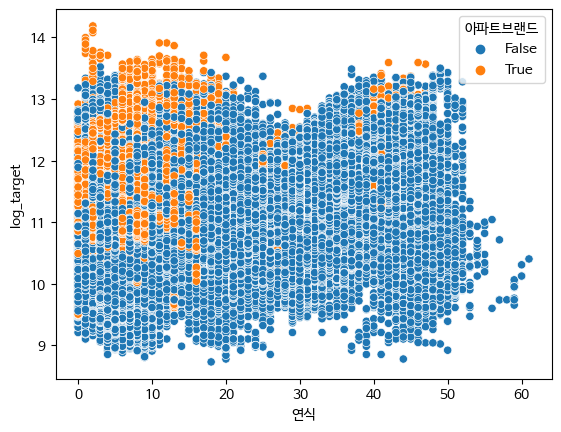

In [183]:
# 아파트 브랜드별 연식과 아파트값의 log와의 비교
sns.scatterplot(data = train2, x = '연식', y = 'log_target', hue = '아파트브랜드')

- 브랜드에 포함되어 있는 아파트는 주로 신축에 가까운 아파트가 많았음
- 그러나 아파트값을 나눌 수 있는 분류는 쉽지 않아 보임

<Axes: xlabel='연식', ylabel='log_target'>

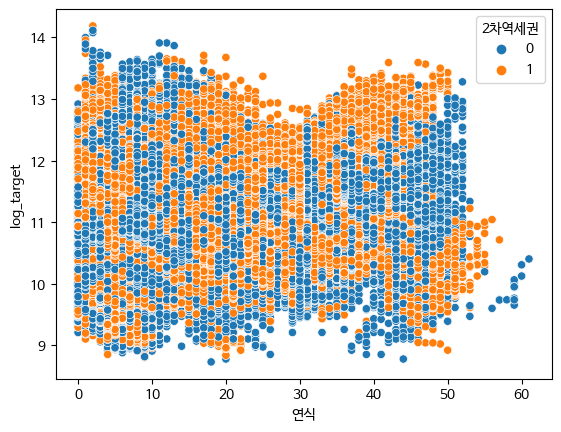

In [184]:
# 역세권에 따른 연식과 log 아파트값
sns.scatterplot(data = train2, x = '연식', y = 'log_target', hue = '2차역세권')

- 역세권에 따라서 아파트의 가격대가 나뉘지 않음
- 역세권의 의미가 크게 없는 것을 확인할 수 있었음

<Axes: xlabel='전용면적', ylabel='target'>

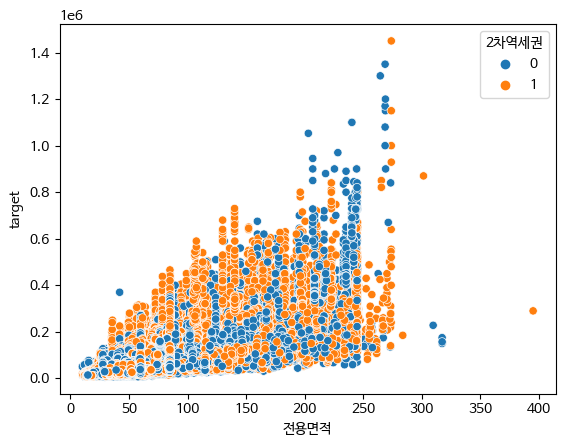

In [185]:
# 전용면적 대비 아파트가격 역세권으로 나눠 확인
sns.scatterplot(data = train2, x = '전용면적', y = 'target', hue = '2차역세권')

- 마찬가지로 의미가 존재하지 않음
- log를 씌워보아도 관계성이 전혀 없어보임

<Axes: xlabel='전용면적', ylabel='log_target'>

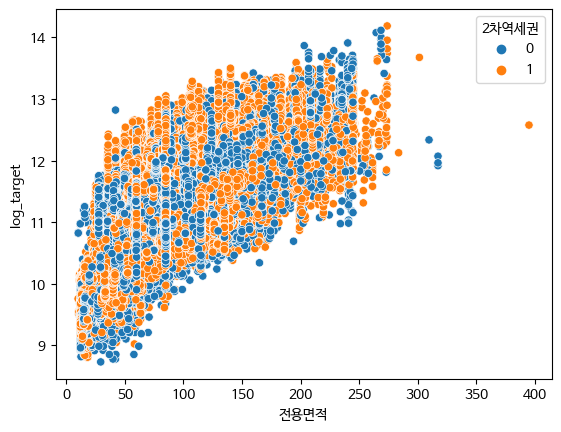

In [186]:
# 위의 그래프에 log
sns.scatterplot(data = train2, x = '전용면적', y = 'log_target', hue = '2차역세권')

<Axes: xlabel='log_target', ylabel='여당득표율'>

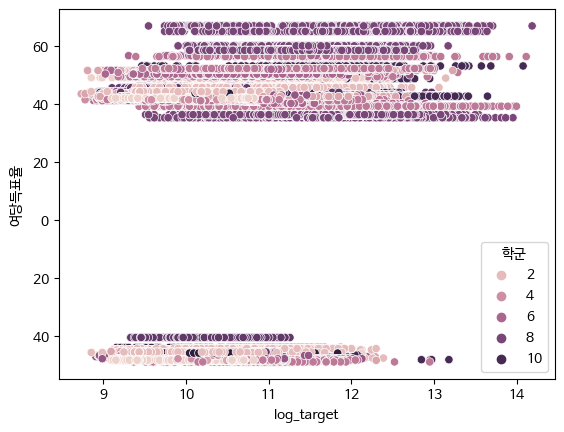

In [188]:
# 학군별 여당 득표율과 log 아파트가격과의 관계
sns.scatterplot(data = train2, x = 'log_target', y = '여당득표율', hue = '학군')

- log 아파트가격을 분류할만한 기준은 없어보임

<Axes: xlabel='학군', ylabel='여당득표율'>

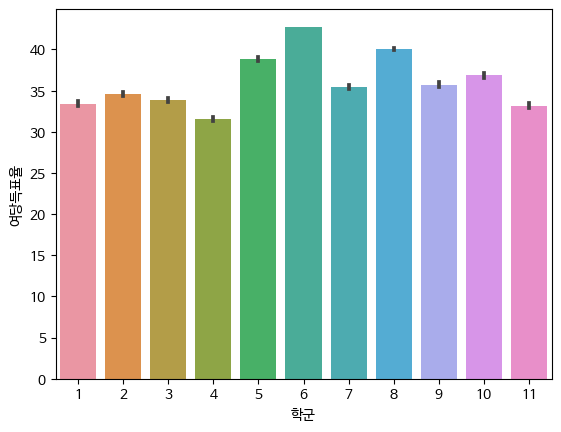

In [189]:
# 학군 별 여당 득표율
sns.barplot(data = train2, y = '여당득표율', x = '학군')

- 6학군이 여당 득표율이 제일 높지만 구분을 할 수 있을정도의 차이가 나지 않음

<Axes: xlabel='학군', ylabel='log_target'>

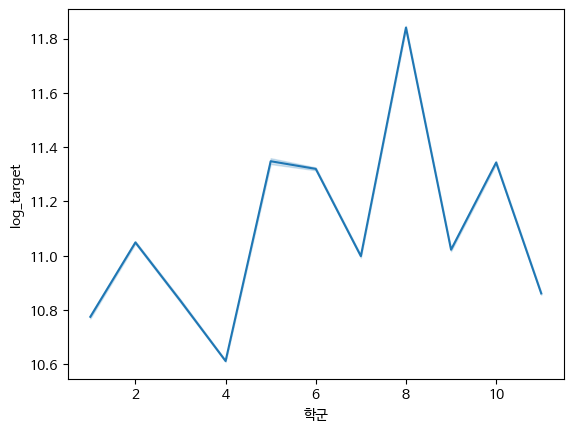

In [190]:
# 학군별 log 아파트가격
sns.lineplot(data = train2, y = 'log_target', x = '학군')

- 확실히 8학군(강남, 서초)에서 높은 값의 아파트가격이 만들어짐

<Axes: xlabel='학군', ylabel='전용면적'>

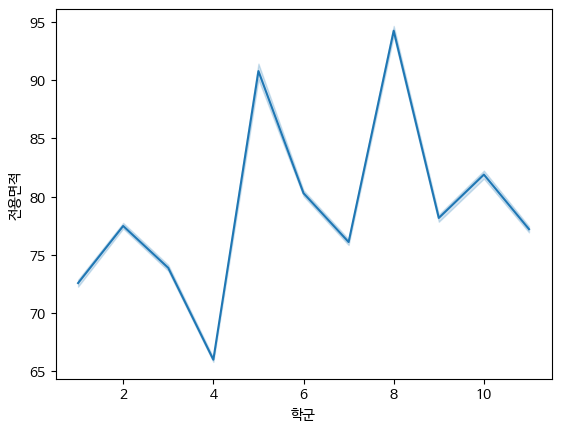

In [191]:
# 학군과 전용면적 관계
sns.lineplot(data = train2, y = '전용면적', x = '학군')

- 학군에 따른 전용면적의 크기가 다르다는 것도 확인할 수 있음
- 자녀의 교육을 위해 강남 및 서초에 밀집해 있는 것을 확인할 수 있음

<Axes: xlabel='학군', ylabel='유동인구'>

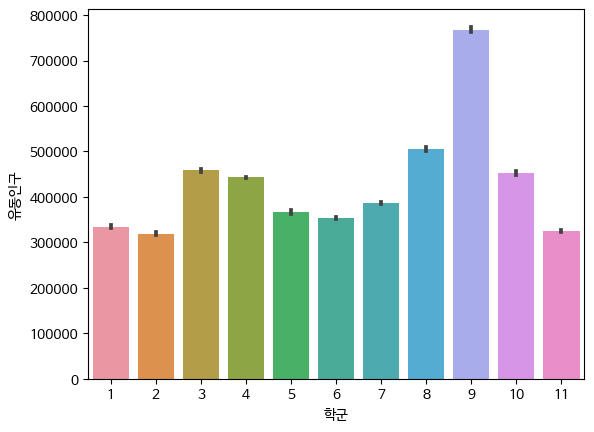

In [192]:
# 학군에 따른 유동인구
sns.barplot(data = train2, y = '유동인구', x = '학군')

- 주로 9학군(동작, 관악)에서 유동인구가 높은 것을 확인할 수 있었음
- 그러나 다음 정보는 신분당선을 제외한 유동인구를 보여주는 것이기 때문에 정확한 값이라 칭하기 어려움

<Axes: xlabel='유동인구', ylabel='log_target'>

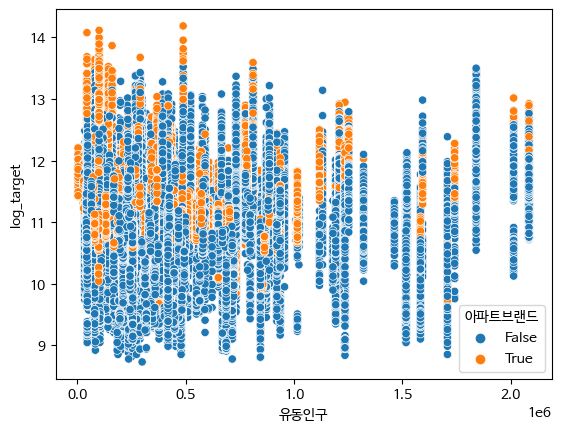

In [193]:
# 아파트 브랜드 여부 유동인구와 log 집값의 관계
sns.scatterplot(data = train2, x = '유동인구', y = 'log_target', hue = '아파트브랜드')

- 관계가 보이지 않음을 알 수 있다.

<Axes: >

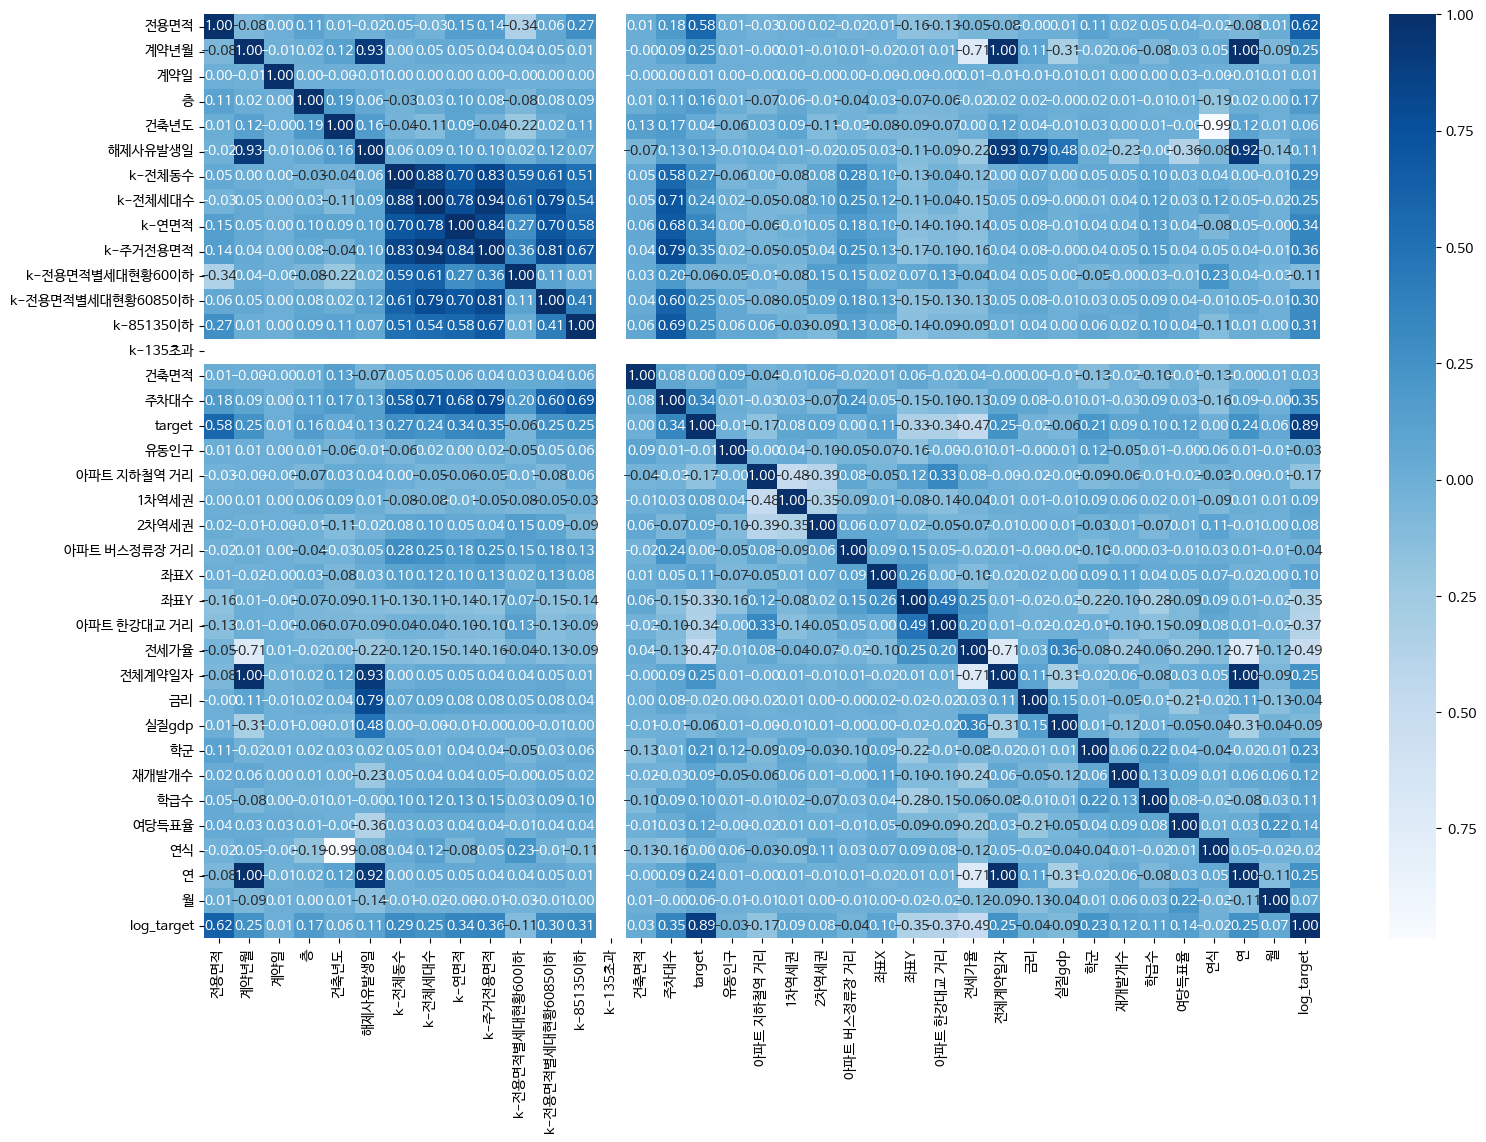

In [194]:
# heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(train2.corr(), annot = True, cmap = 'Blues', fmt = '.2f')

- heatmap에서 확인해봤을 때 결측치가 많이 존재하는 k-변수들간의 관계가 밀접한 것을 확인 할 수 있음
- 좌표Y와 한강대교거리, 전세가율이 아파트 가격과 어느정도 상관관계가 존재하는 것을 확인할 수 있었음

<Axes: xlabel='전세가율', ylabel='log_target'>

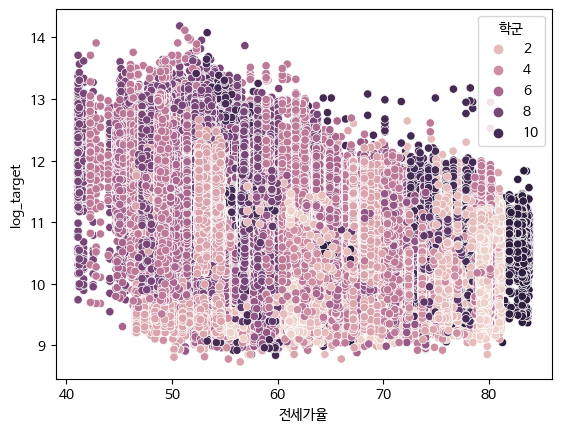

In [196]:
# 학군별 전세가율과 log 집값의 관계
sns.scatterplot(data = train2, x = '전세가율', y = 'log_target', hue = '학군')

- 그렇게 유의한 관계를 보이고 있지 않음

<Axes: xlabel='아파트 한강대교 거리', ylabel='log_target'>

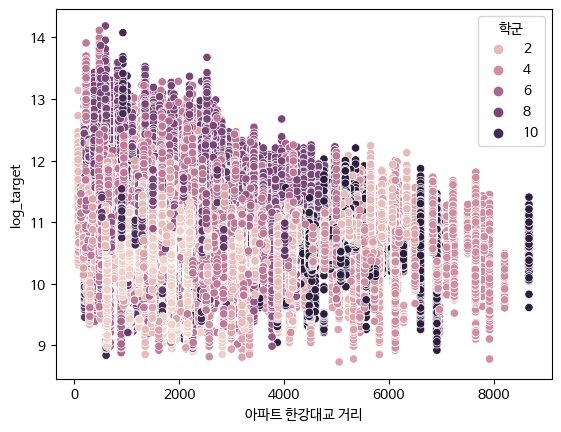

In [197]:
# 아파트 한강대교 거리와 log 집값의 관계
sns.scatterplot(data = train2, x = '아파트 한강대교 거리', y = 'log_target', hue = '학군')

- 마찬가지로 강한 관계성을 보이지 않음

<Axes: xlabel='계약년월', ylabel='target'>

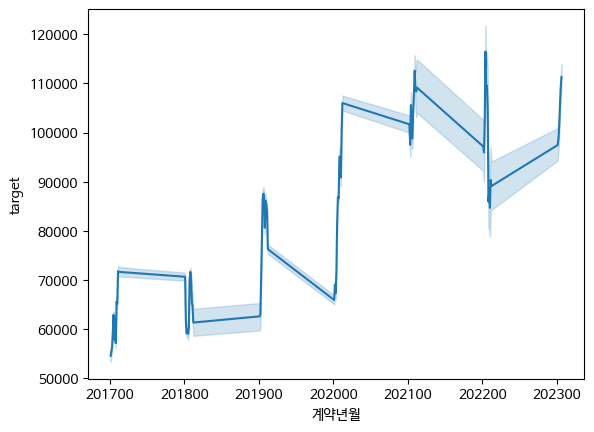

In [198]:
# 계약년월 별 아파트 가격
sns.lineplot(data = train2, x = '계약년월', y = 'target')

- 2017년부터 시작해 2023년까지 값이 커지는 것을 확인할 수 있었음
- 이로인해 시계열로 확인할 수 있었지만 아파트별로 data에 없는 아파트가 존재했음

In [199]:
train2.groupby('계약년월').mean()['target']

계약년월
201701     54571.723866
201702     55380.248119
201703     56335.802427
201704     59371.504344
201705     62943.225892
              ...      
202302     98888.332017
202303    101685.215054
202304    105624.906462
202305    109265.920184
202306    111301.393625
Name: target, Length: 78, dtype: float64

<Axes: xlabel='월', ylabel='target'>

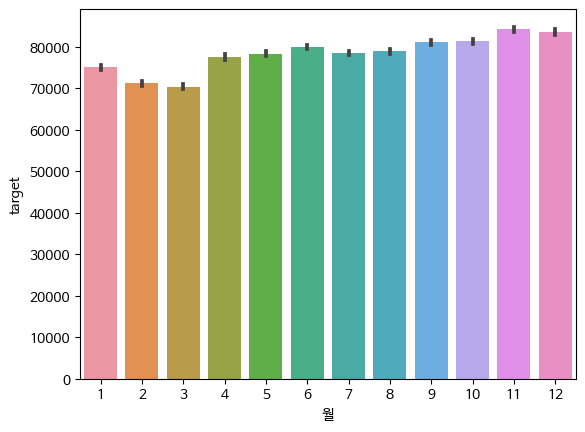

In [200]:
# 월별 아파트가
sns.barplot(data = train2, x = '월', y = 'target')

<Axes: xlabel='연', ylabel='target'>

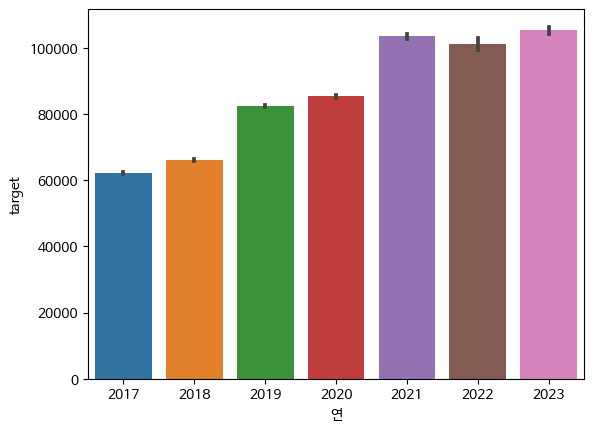

In [201]:
# 연도별 아파트가
sns.barplot(data = train2, x = '연', y = 'target')

- 연도별 추세선은 확실히 볼 수 있음
- 월별 아파트 가격은 의미 없음

In [202]:
train2.columns

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명',
       '해제사유발생일', '거래유형', '중개사소재지', 'k-단지분류', 'k-세대타입(분양형태)', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사', 'k-시행사', 'k-연면적', 'k-주거전용면적',
       'k-전용면적별세대현황60이하', 'k-전용면적별세대현황6085이하', 'k-85135이하', 'k-135초과',
       '세대전기계약방법', '건축면적', '주차대수', '기타의무임대1234', '단지신청일', 'target', '구', '동',
       '전체주소명', '동아파트명', '유동인구', '아파트 지하철역 거리', '1차역세권', '2차역세권',
       '아파트 버스정류장 거리', '좌표X', '좌표Y', '아파트 한강대교 거리', '전세가율', '전체계약일자', '금리',
       '실질gdp', '명목gdp', '학군', '재개발개수', '학급수', '여당득표율', '아파트브랜드', '연식', '연',
       '월', 'log_target', '건축'],
      dtype='object')

In [203]:
train['동아파트명'].unique()

array(['개포동 개포6차우성', '개포동 개포우성3차', '개포동 개포자이', ..., '신당동 마이스터빌', '신당동 하영',
       '신내동 건영1'], dtype=object)

- 금리는 해당 년도보다 다음 년도에 값이 잘 반영된다고 함
- 따라서 각 계약시점보다 11개월전 ~ 13개월전의 값을 확인하여 비교해보기로 함

In [204]:
# 계약날짜를 년월에서 년월일로 합체
goldwe["일자년월일"] = goldwe["변경일자_년"].astype(str) + goldwe["변경일자_월일"].map(lambda x : x[:2] + x[4:6])

In [222]:
# 순차적으로 나열할 수 있게끔 sort
g01 = goldwe.sort_values('일자년월일')
g01['날짜열_1년후'] = pd.to_datetime(g01['일자년월일']) + pd.DateOffset(years=1)
g01['날짜열_11개월후'] = pd.to_datetime(g01['일자년월일']) + pd.DateOffset(months=11)
g01['날짜열_13개월후'] = pd.to_datetime(g01['일자년월일']) + pd.DateOffset(months=13)

In [223]:
# 각 11개월전, 12개월전, 13개월전 금리를 계산
g02 = g01[['날짜열_11개월후', '기준금리']]
g03 = g01[['날짜열_1년후', '기준금리']]
g04 = g01[['날짜열_13개월후', '기준금리']]

g02.columns = ['날짜열_11개월후', "11개월전_금리"]
g03.columns = ['날짜열_1년후', "1년전_금리"]
g04.columns = ['날짜열_13개월후', "13개월전_금리"]

g02['날짜열_11개월후_종료일'] = g02['날짜열_11개월후'].shift(-1, fill_value = "2027-01-01") - pd.DateOffset(days=1)
g03['날짜열_1년후_종료일'] = g03['날짜열_1년후'].shift(-1, fill_value = "2027-01-01") - pd.DateOffset(days=1)
g04['날짜열_13개월후_종료일'] = g04['날짜열_13개월후'].shift(-1, fill_value = "2027-01-01") - pd.DateOffset(days=1)

In [225]:
# 변경일자년월일 생성
train2["일자년월일"] = train2["계약년월"].astype(str)+train2["계약일"].astype(str).str.zfill(2)
train2["일자년월일"] = pd.to_datetime(train2["일자년월일"])

In [226]:
# 데이터 따로 보기
make_date = train2["일자년월일"].reset_index()

In [227]:
# 하버사인 거리 계산하듯 전체 날짜의 차이를 계산
m02 = pd.merge(make_date, g02, how = 'cross')
m03 = pd.merge(make_date, g03, how = 'cross')
m04 = pd.merge(make_date, g04, how = 'cross')

In [230]:
# 값의 차이를 이용해 + 곱하기 -는 -가 되는 성질을 활용해 각 날짜의 금리에 대해 대입
m02['현재와시작일차이'] = (m02['일자년월일'] - m02['날짜열_11개월후']).dt.days
m02['현재와종료일차이'] = (m02['날짜열_11개월후_종료일'] - m02['일자년월일']).dt.days
m02['체크'] = m02['현재와시작일차이']*m02['현재와종료일차이']

m03['현재와시작일차이'] = (m03['일자년월일'] - m03['날짜열_1년후']).dt.days
m03['현재와종료일차이'] = (m03['날짜열_1년후_종료일'] - m03['일자년월일']).dt.days
m03['체크'] = m03['현재와시작일차이']*m03['현재와종료일차이']

m04['현재와시작일차이'] = (m04['일자년월일'] - m04['날짜열_13개월후']).dt.days
m04['현재와종료일차이'] = (m04['날짜열_13개월후_종료일'] - m04['일자년월일']).dt.days
m04['체크'] = m04['현재와시작일차이']*m04['현재와종료일차이']

In [212]:
# 두 값을 곱했을 때 양수가 나오는 범위는 하나뿐이므로 그 값을 가져옴
m02[m02['체크'] >= 0]
m03[m03['체크'] >= 0]
m04[m04['체크'] >= 0]

,index,일자년월일,날짜열_11개월후,11개월전_금리,날짜열_11개월후_종료일,현재와시작일차이,현재와종료일차이,체크
38,0,2017-12-08,2017-05-09,1.25,2018-10-29,213,325,69225
93,1,2017-12-22,2017-05-09,1.25,2018-10-29,227,311,70597
148,2,2017-12-28,2017-05-09,1.25,2018-10-29,233,305,71065
203,3,2018-01-03,2017-05-09,1.25,2018-10-29,239,299,71461
258,4,2018-01-08,2017-05-09,1.25,2018-10-29,244,294,71736
...,...,...,...,...,...,...,...,...
22892963,601131,2017-07-31,2017-05-09,1.25,2018-10-29,83,455,37765
22893018,601132,2017-07-31,2017-05-09,1.25,2018-10-29,83,455,37765
22893073,601133,2017-08-03,2017-05-09,1.25,2018-10-29,86,452,38872
22893128,601134,2017-08-12,2017-05-09,1.25,2018-10-29,95,443,42085


In [231]:
# 기존에 가지고 있던 index 번호를 다시 index로 
m02.set_index('index', inplace=True)
m03.set_index('index', inplace=True)
m04.set_index('index', inplace=True)

In [232]:
# 최종적으로 금리 데이터 붙이기
train3 = pd.concat([train2, m02['11개월전_금리'][m02['체크'] >= 0]], axis = 1)
train2 = pd.concat([train3, m03['1년전_금리'][m03['체크'] >= 0]], axis = 1)
train3 = pd.concat([train2, m04['13개월전_금리'][m04['체크'] >= 0]], axis = 1)

<Axes: xlabel='11개월전_금리', ylabel='target'>

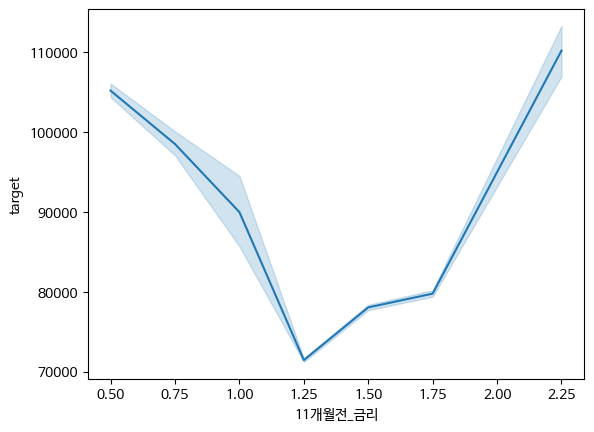

In [234]:
# 11개월전 금리
sns.lineplot(data = train3, x = '11개월전_금리', y = 'target')

<Axes: xlabel='계약년월', ylabel='target'>

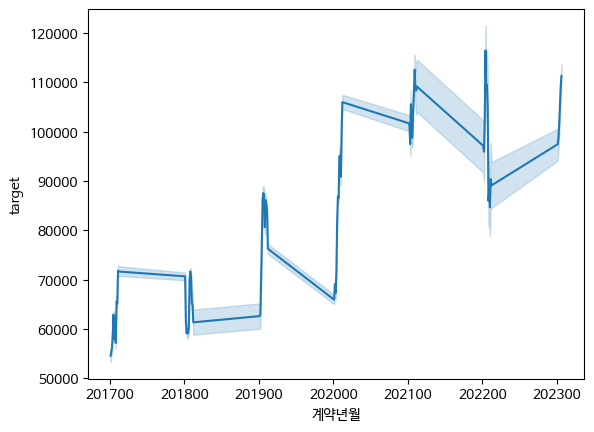

In [240]:
# 계약년월별 아파트가격
sns.lineplot(data = train3, x = '계약년월', y = 'target')

<Axes: xlabel='13개월전_금리', ylabel='target'>

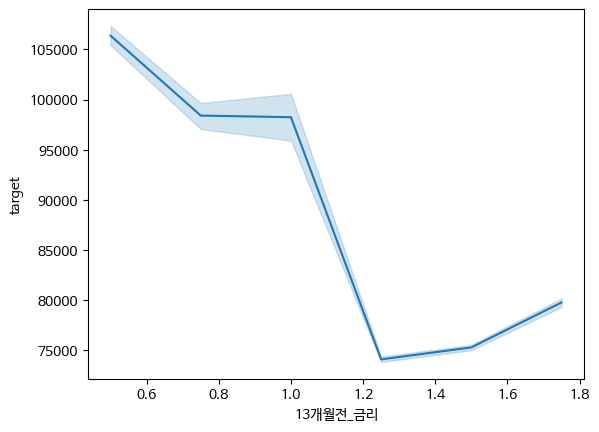

In [238]:
# 13개월전 금리
sns.lineplot(data = train3, x = '13개월전_금리', y = 'target')

<Axes: xlabel='금리', ylabel='target'>

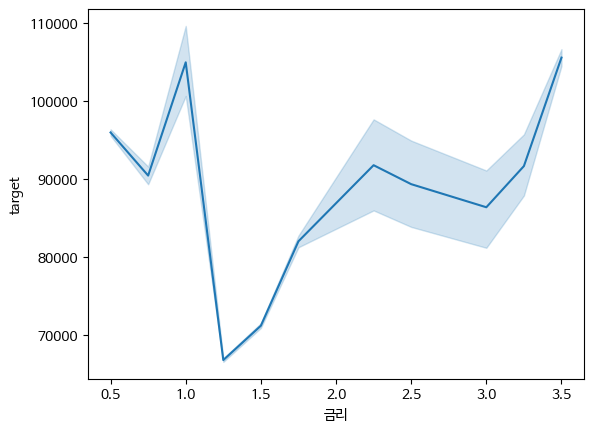

In [239]:
# 현재 금리에 따라 변하는 아파트가
sns.lineplot(data = train3, x = '금리', y = 'target')

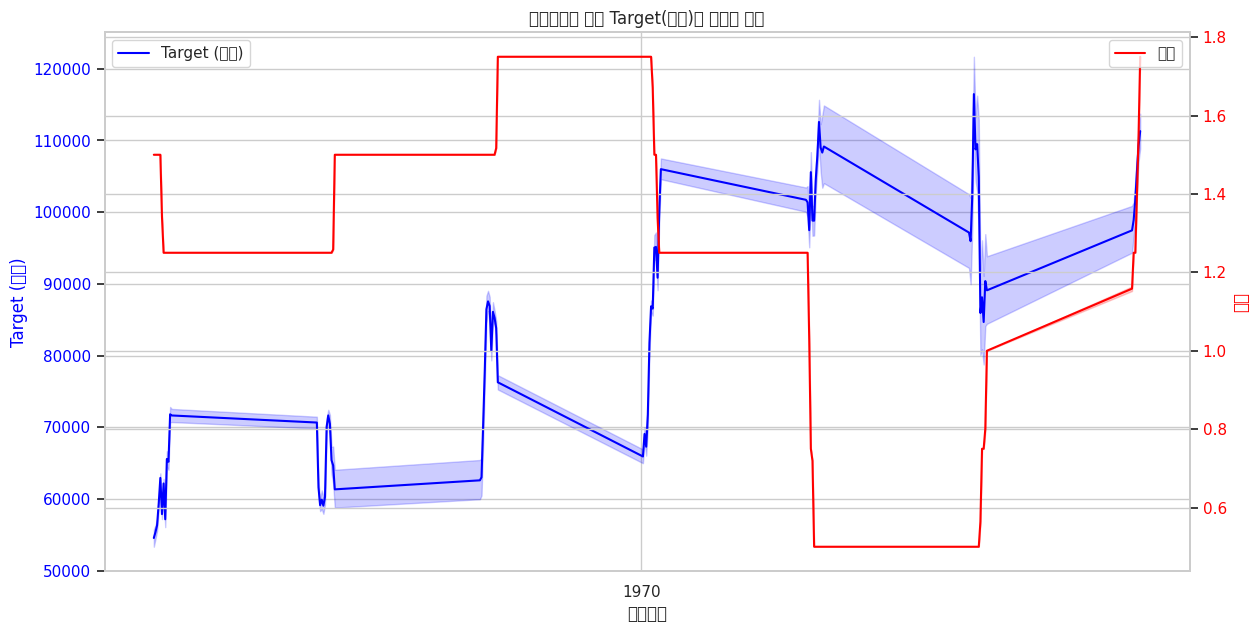

In [246]:

# 스타일 설정
sns.set_theme(style="whitegrid")

# 데이터 불러오기
data = train3

# '계약년월'을 datetime 형식으로 변환
data['계약년월'] = pd.to_datetime(data['계약년월'])

# 데이터 정렬
data.sort_values('계약년월', inplace=True)

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(14, 7))

# Seaborn을 사용하여 'target'에 대한 라인 그래프 생성
sns.lineplot(x='계약년월', y='target', data=data, color='blue', label='Target (집값)', ax=ax1)

# 라벨 설정
ax1.set_xlabel('계약년월')
ax1.set_ylabel('Target (집값)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 새로운 축 생성 후 '금리'에 대한 라인 그래프 생성
ax2 = ax1.twinx()
sns.lineplot(x='계약년월', y='1년전_금리', data=data, color='red', label='금리', ax=ax2)

# 라벨 및 타이틀 설정
ax2.set_ylabel('금리', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('계약년월에 따른 Target(집값)과 금리의 변동')

# 범례 설정
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 그래프 표시
plt.show()


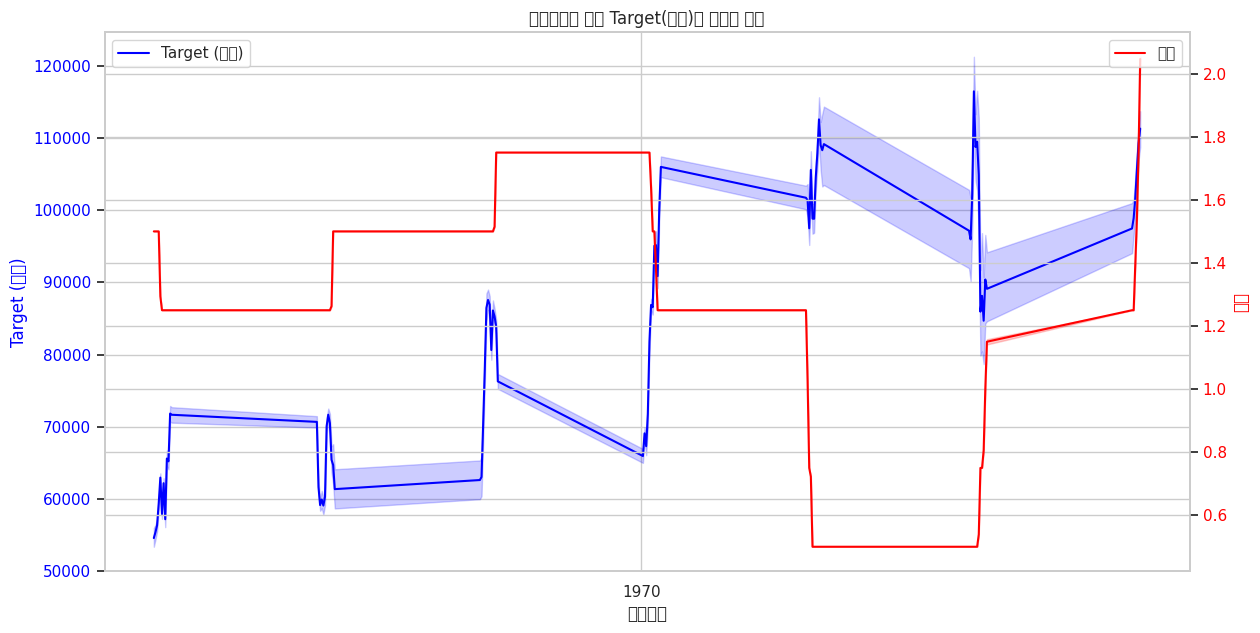

In [248]:

# 스타일 설정
sns.set_theme(style="whitegrid")

# 데이터 불러오기
data = train3

# '계약년월'을 datetime 형식으로 변환
data['계약년월'] = pd.to_datetime(data['계약년월'])

# 데이터 정렬
data.sort_values('계약년월', inplace=True)

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(14, 7))

# Seaborn을 사용하여 'target'에 대한 라인 그래프 생성
sns.lineplot(x='계약년월', y='target', data=data, color='blue', label='Target (집값)', ax=ax1)

# 라벨 설정
ax1.set_xlabel('계약년월')
ax1.set_ylabel('Target (집값)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 새로운 축 생성 후 '금리'에 대한 라인 그래프 생성
ax2 = ax1.twinx()
sns.lineplot(x='계약년월', y='11개월전_금리', data=data, color='red', label='금리', ax=ax2)

# 라벨 및 타이틀 설정
ax2.set_ylabel('금리', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('계약년월에 따른 Target(집값)과 금리의 변동')

# 범례 설정
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 그래프 표시
plt.show()


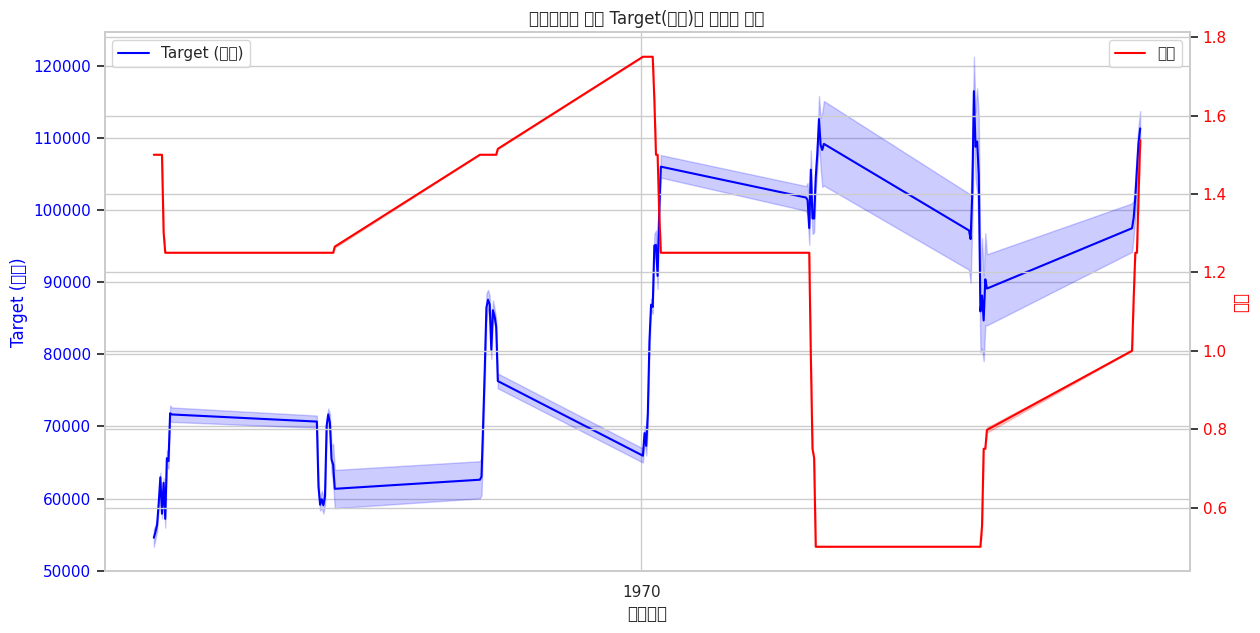

In [249]:

# 스타일 설정
sns.set_theme(style="whitegrid")

# 데이터 불러오기
data = train3

# '계약년월'을 datetime 형식으로 변환
data['계약년월'] = pd.to_datetime(data['계약년월'])

# 데이터 정렬
data.sort_values('계약년월', inplace=True)

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(14, 7))

# Seaborn을 사용하여 'target'에 대한 라인 그래프 생성
sns.lineplot(x='계약년월', y='target', data=data, color='blue', label='Target (집값)', ax=ax1)

# 라벨 설정
ax1.set_xlabel('계약년월')
ax1.set_ylabel('Target (집값)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 새로운 축 생성 후 '금리'에 대한 라인 그래프 생성
ax2 = ax1.twinx()
sns.lineplot(x='계약년월', y='13개월전_금리', data=data, color='red', label='금리', ax=ax2)

# 라벨 및 타이틀 설정
ax2.set_ylabel('금리', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('계약년월에 따른 Target(집값)과 금리의 변동')

# 범례 설정
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 그래프 표시
plt.show()


- 그래프 3개는 각각 11, 12, 13개월전 금리의 변화에 따른 집값의 변화를 그려준 그래프이다.
- 이는 금리와 아파트가가 연관이 있음을 보여주고 있다.

In [ ]:
# 층, 아파트 한강과의 거리, 거리 1km 이내에서 / 이외에서 아파트 층별 값 어떻게 변화하는지
# 분열 기준을 내가 정해도 되고 좋은 기준이 있으면 반영해도 좋다.
# 방향이 생기면 너무 좋다. 

In [108]:
# 거리가 2km기준보다 작은 값이면 1 아니면 0
train2['한강일까요'] = np.where(train2['아파트 한강대교 거리'] <= 2000, 1, 0)

- 한강에 가까이 있고 집의 층이 높으면 한강뷰가 매우 잘 보일 가능성이 높음
- 따라서 한강에 대한 조망권이 아파트의 가격을 올려줄거라 예상됨

In [109]:
# 한강 조망권 + 층별 평균가격
train2.groupby(['한강일까요', '층']).mean()['target']

한강일까요  층  
0      -3      82250.000000
       -2      71566.666667
       -1      60496.875000
        1      57400.596169
        2      58689.413130
                  ...      
1       65    173000.000000
        66    214000.000000
        67    180500.000000
        68    156750.000000
        69    183000.000000
Name: target, Length: 140, dtype: float64

<Axes: xlabel='층', ylabel='target'>

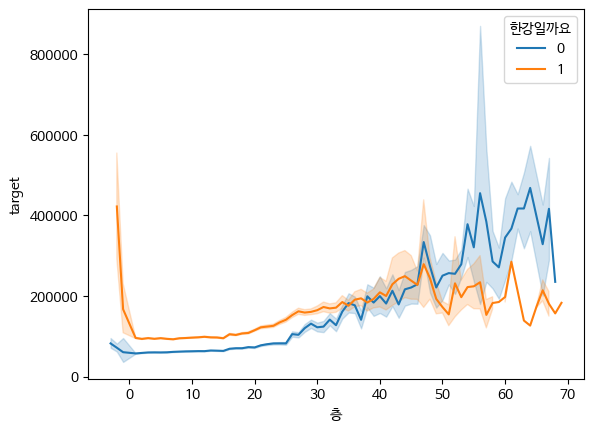

In [110]:
# 층별 한강그룹별 아파트 가격
sns.lineplot(data= train2, x = '층', y = 'target', hue = '한강일까요')

- 30층 이전까지만해도 한강뷰의 가격이 높았지만, 30층 이후 약 35층부터 고층일 수록 한강이 아닌곳이 높았음
- 한강의 뷰를 볼 수 있는 곳은 가격이 매우 크다.